In [1]:
import sys

sys.path.append("../..")

import pandas as pd

data_root_dir = "../data/sun_et_al_data/"


def print_full_df(x):
    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    pd.set_option("display.max_colwidth", None)
    display(x)
    pd.reset_option("display.max_rows")
    pd.reset_option("display.max_columns")
    pd.reset_option("display.width")
    pd.reset_option("display.float_format")
    pd.reset_option("display.max_colwidth")


def do_necessary_preprocessing(sample_group, mpa4_species_profile):
    studies_to_remove = ["LiS_2021a", "LiS_2021b"]
    columns_to_keep = ["Sample", "Group", "Project", "Project_1"]
    # Remove studies
    sample_group = sample_group[~sample_group["Project_1"].isin(studies_to_remove)]

    # Keep recommended columns
    sample_group = sample_group[columns_to_keep]
    # Set index to Sample
    sample_group = sample_group.set_index("Sample")

    # Remove species with no reads
    mpa4_species_profile = mpa4_species_profile.loc[
        :, mpa4_species_profile.sum(axis=0) >= 1
    ]

    ## Remove repeated samples
    sample_group = sample_group[~sample_group.index.duplicated(keep="first")]

    # remove samples not in sample_group
    samples_to_keep = list(
        set(sample_group.index.tolist()) & set(mpa4_species_profile.columns.tolist())
    )
    mpa4_species_profile = mpa4_species_profile[samples_to_keep]

    mpa4_species_profile = mpa4_species_profile.T

    # remove samples from sample_group that are not in mpa4_species_profile
    sample_group = sample_group.loc[samples_to_keep]

    return sample_group, mpa4_species_profile


# getting data
## not preprocessed data
mpa4_species_profile = pd.read_table(
    f"{data_root_dir}/mpa4_species.profile", sep="\t", header=0, index_col=0
)
sample_group = pd.read_table(f"{data_root_dir}/sample.group", sep="\t", header=0)
### we still need to remove samples without metadata, and some other stuff
sample_group, mpa4_species_profile = do_necessary_preprocessing(
    sample_group, mpa4_species_profile
)

## preprocessed data
mpa4_species_profile_preprocessed = pd.read_csv(
    f"{data_root_dir}/mpa4_species_profile_preprocessed.csv", header=0, index_col=0
)
sample_group_preprocessed = pd.read_csv(
    f"{data_root_dir}/sample_group_preprocessed.csv", header=0, index_col=0
)

# Decreasing feature space by focusing on specific species
species_to_keep = [
    "s__Phocaeicola_vulgatus",
    "s__Prevotella_copri_clade_A",
    "s__Faecalibacterium_prausnitzii",
    "s__Bacteroides_uniformis",
    "s__Phocaeicola_plebeius",
    "s__Bacteroides_stercoris",
    "s__Phocaeicola_dorei",
    "s__Alistipes_putredinis",
    "s__Eubacterium_rectale",
    "s__Escherichia_coli",
    "s__Bacteroides_ovatus",
    "s__Bacteroides_fragilis",
    "s__Phocaeicola_coprocola",
    "s__Prevotella_copri_clade_C",
    "s__Megamonas_funiformis",
    "s__Ruminococcus_bromii",
    "s__Bacteroides_thetaiotaomicron",
    "s__Roseburia_faecis",
    "s__Phocaeicola_massiliensis",
    "s__Parabacteroides_distasonis",
]

# mpa4_species_profile_desired = mpa4_species_profile[species_to_keep]
# others = mpa4_species_profile[list(set(mpa4_species_profile.columns) - set(species_to_keep))]
# others = pd.DataFrame(others.sum(axis=1), columns=["other"])
# mpa4_species_profile_desired = pd.concat([mpa4_species_profile_desired, others], axis=1, join="outer")
# mpa4_species_profile = mpa4_species_profile_desired
# del mpa4_species_profile_desired
# del others

# mpa4_species_profile_desired = mpa4_species_profile_preprocessed[species_to_keep]
# others = mpa4_species_profile_preprocessed[list(set(mpa4_species_profile_preprocessed.columns) - set(species_to_keep))]
# others = pd.DataFrame(others.sum(axis=1), columns=["other"])
# mpa4_species_profile_desired = pd.concat([mpa4_species_profile_desired, others], axis=1, join="outer")
# mpa4_species_profile_preprocessed = mpa4_species_profile_desired
# del mpa4_species_profile_desired
# del others

print("Not preprocessed data")
print(mpa4_species_profile.shape, sample_group.shape)
display(mpa4_species_profile.head())
display(sample_group.head())

print("Preprocessed data")
print(mpa4_species_profile_preprocessed.shape, sample_group_preprocessed.shape)
display(mpa4_species_profile_preprocessed.head())
display(sample_group_preprocessed.head())


Not preprocessed data
(6303, 2557) (6303, 3)


name,s__Phocaeicola_plebeius,s__Faecalibacterium_prausnitzii,s__Ruminococcus_sp_NSJ_71,s__Eubacterium_rectale,s__Bacteroides_uniformis,s__Clostridium_sp_AF15_49,s__Lachnospira_eligens,s__Roseburia_sp_AF02_12,s__Phocaeicola_vulgatus,s__Ruminococcus_bicirculans,...,s__Rodentibacter_myodis,s__Rhodococcus_hoagii,s__Pseudomonas_psychrophila,s__Pseudomonas_sp_DG56_2,s__Providencia_rustigianii,s__Pseudomonas_vranovensis,s__Pseudomonas_taetrolens,s__Pseudomonas_deceptionensis,s__Desulfobulbus_oralis,s__Bacteroides_reticulotermitis
SRR341666,8.35611,3.12809,0.00000,1.74240,0.85553,0.06147,1.72574,0.0,0.04701,0.03087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAMEA2737675,16.33515,0.11324,0.00000,0.16594,1.51422,0.00000,0.25481,0.0,9.82890,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2017651,0.00000,0.55784,0.00000,0.07314,0.80021,0.00575,1.79485,0.0,2.80037,0.16437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR2855916,27.11783,2.48043,0.00000,1.83322,8.20323,0.00000,0.00000,0.0,6.96508,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13336925,0.00000,15.18232,0.00815,0.00000,0.02744,0.00000,0.55846,0.0,2.72456,0.14380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Group,Project,Project_1
Sample,,,
SRR341666,Disease,QinJ_2012.T2D,QinJ_2012
SAMEA2737675,Disease,ZhangX_2015.RA,ZhangX_2015
ERR2017651,Disease,JieZ_2017.ACVD,JieZ_2017
ERR2855916,Disease,ZhuF_2020.SCZ,ZhuF_2020
SRR13336925,Disease,LiuP_2021.MG,LiuP_2021


Preprocessed data
(6303, 2557) (6303, 3)


,s__Phocaeicola_plebeius,s__Faecalibacterium_prausnitzii,s__Ruminococcus_sp_NSJ_71,s__Eubacterium_rectale,s__Bacteroides_uniformis,s__Clostridium_sp_AF15_49,s__Lachnospira_eligens,s__Roseburia_sp_AF02_12,s__Phocaeicola_vulgatus,s__Ruminococcus_bicirculans,...,s__Rodentibacter_myodis,s__Rhodococcus_hoagii,s__Pseudomonas_psychrophila,s__Pseudomonas_sp_DG56_2,s__Providencia_rustigianii,s__Pseudomonas_vranovensis,s__Pseudomonas_taetrolens,s__Pseudomonas_deceptionensis,s__Desulfobulbus_oralis,s__Bacteroides_reticulotermitis
SRR12005688,-0.002525,0.344477,-0.002525,0.500240,-0.002525,0.208532,0.178621,-0.002525,-0.002525,0.101813,...,-0.002525,-0.002525,-0.002525,-0.002525,-0.002525,-0.002525,-0.002525,-0.002525,-0.002525,-0.002525
SRR8898458,0.018546,0.112886,-0.002603,0.275621,0.014039,-0.002603,-0.002603,-0.002603,-0.002603,0.035871,...,-0.002603,-0.002603,-0.002603,-0.002603,-0.002603,-0.002603,-0.002603,-0.002603,-0.002603,-0.002603
ERR1398105,-0.001080,0.071730,-0.001080,-0.001080,0.018741,-0.001080,-0.001080,-0.001080,0.221522,-0.001080,...,-0.001080,-0.001080,-0.001080,-0.001080,-0.001080,-0.001080,-0.001080,-0.001080,-0.001080,-0.001080
ERR1190566,0.026247,0.204353,-0.003151,0.174351,0.044989,0.097026,0.131213,-0.003151,0.156197,-0.003151,...,-0.003151,-0.003151,-0.003151,-0.003151,-0.003151,-0.003151,-0.003151,-0.003151,-0.003151,-0.003151
SRR413675,-0.002723,0.183455,-0.002723,-0.002723,0.198567,-0.002723,0.092785,-0.002723,-0.002723,0.050788,...,-0.002723,-0.002723,-0.002723,-0.002723,-0.002723,-0.002723,-0.002723,-0.002723,-0.002723,-0.002723


,Group,Project,Project_1
Sample,,,
SRR12005688,Disease,ZhuQ_2021.GD,ZhuQ_2021
SRR8898458,Disease,ChenB_2020.SLE,ChenB_2020
ERR1398105,Disease,LiJ_2017.HTN,LiJ_2017
ERR1190566,Disease,LiuR_2017.OB,LiuR_2017
SRR413675,Disease,QinJ_2012.T2D,QinJ_2012


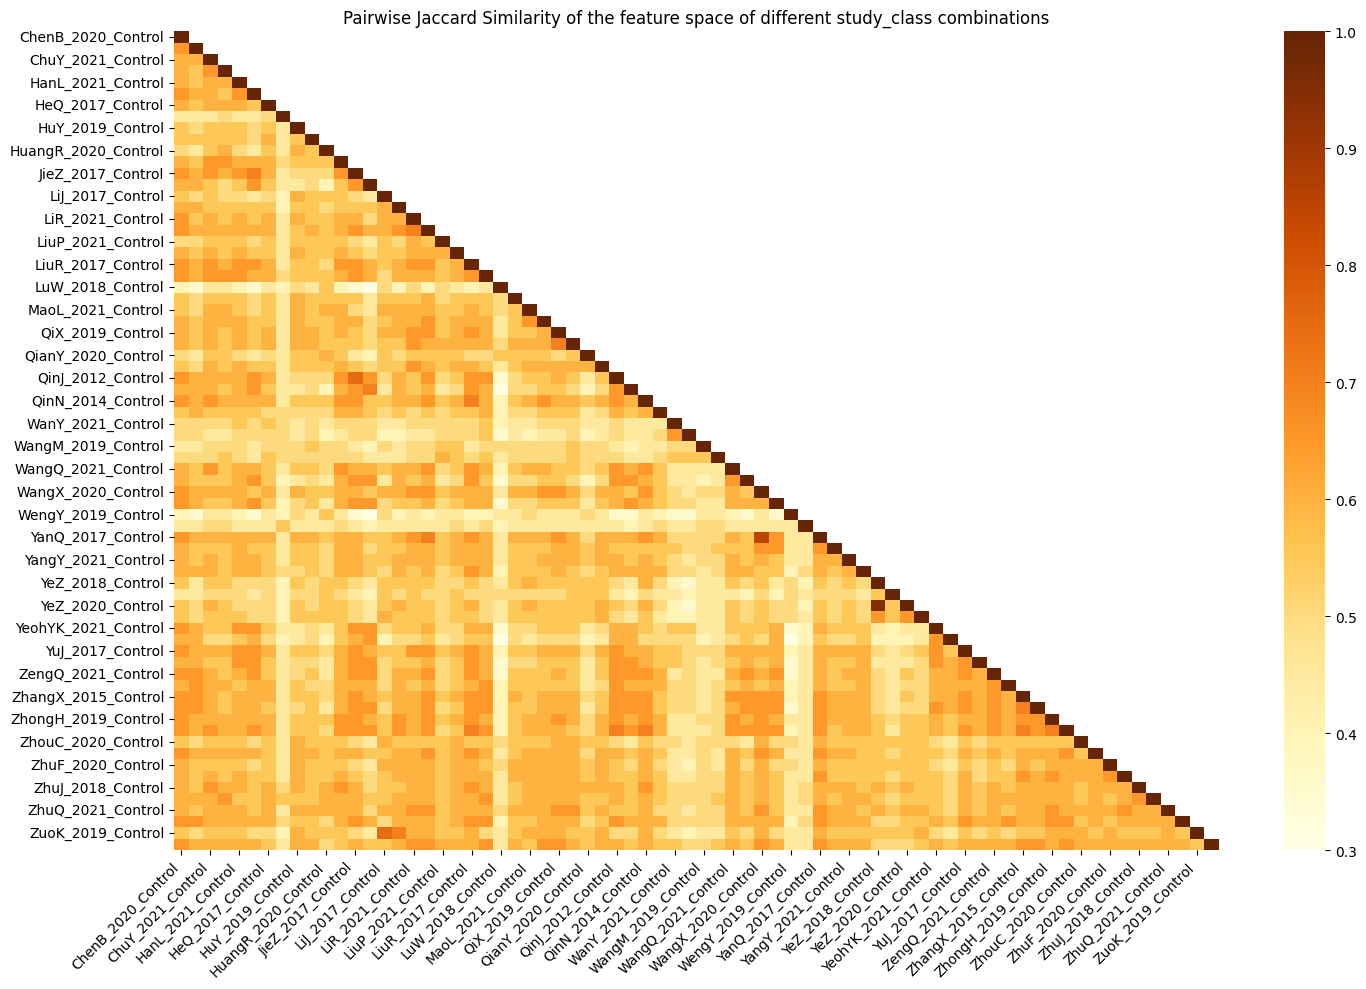

Value counts of pairwise Jaccard Similarity of the feature space of different study_class combinations


0
0.60    735
0.55    694
0.50    443
0.45    307
0.65    247
0.40     83
1.00     72
0.35     25
0.70     13
0.30      5
0.75      2
0.85      1
0.95      1
Name: count, dtype: int64

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

grouped_by_project = sample_group.groupby(sample_group["Project_1"])
studywise_labelwise_nonzero_features = {}

for group, group_df in grouped_by_project:
    for label, indices in group_df.groupby("Group").groups.items():
        df = mpa4_species_profile.loc[indices]
        df_filtered = df.loc[
            :, (df.abs().sum(axis=0) != 0)
        ]  # TODO add absolute values function first (maybe negatives)
        studywise_labelwise_nonzero_features[f"{group}_{label}"] = set(
            list(df_filtered.columns)
        )

keys = list(studywise_labelwise_nonzero_features.keys())
n = len(keys)
jaccard_mat = np.zeros((n, n))

# Jaccard similarity calculation: defined as: |A ∩ B| / |A ∪ B|
for i in range(n):
    for j in range(n):
        set1 = studywise_labelwise_nonzero_features[keys[i]]
        set2 = studywise_labelwise_nonzero_features[keys[j]]
        # Calculate the intersection and union sizes:
        intersection_size = len(set1.intersection(set2))
        union_size = len(set1.union(set2))
        # Avoid division by zero
        jaccard_mat[i, j] = intersection_size / union_size if union_size > 0 else np.nan

# Create a DataFrame from the matrix for easier plotting
jaccard_df = pd.DataFrame(jaccard_mat, index=keys, columns=keys)


# Plot a heatmap using seaborn
def round_nearest(x, a):
    return round(x / a) * a


jaccard_df_rounded = round_nearest(jaccard_df, 0.05).where(
    np.tril(np.ones(jaccard_df.shape)).astype(np.bool)
)
plt.figure(figsize=(15, 10))
sns.heatmap(
    jaccard_df_rounded,
    annot=False,
    cmap=sns.color_palette("YlOrBr", as_cmap=True),
    fmt=".1f",
)
plt.title(
    "Pairwise Jaccard Similarity of the feature space of different study_class combinations"
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


jaccard_df_rounded = jaccard_df_rounded.stack().reset_index()
print(
    "Value counts of pairwise Jaccard Similarity of the feature space of different study_class combinations"
)
print_full_df(jaccard_df_rounded[0].value_counts())

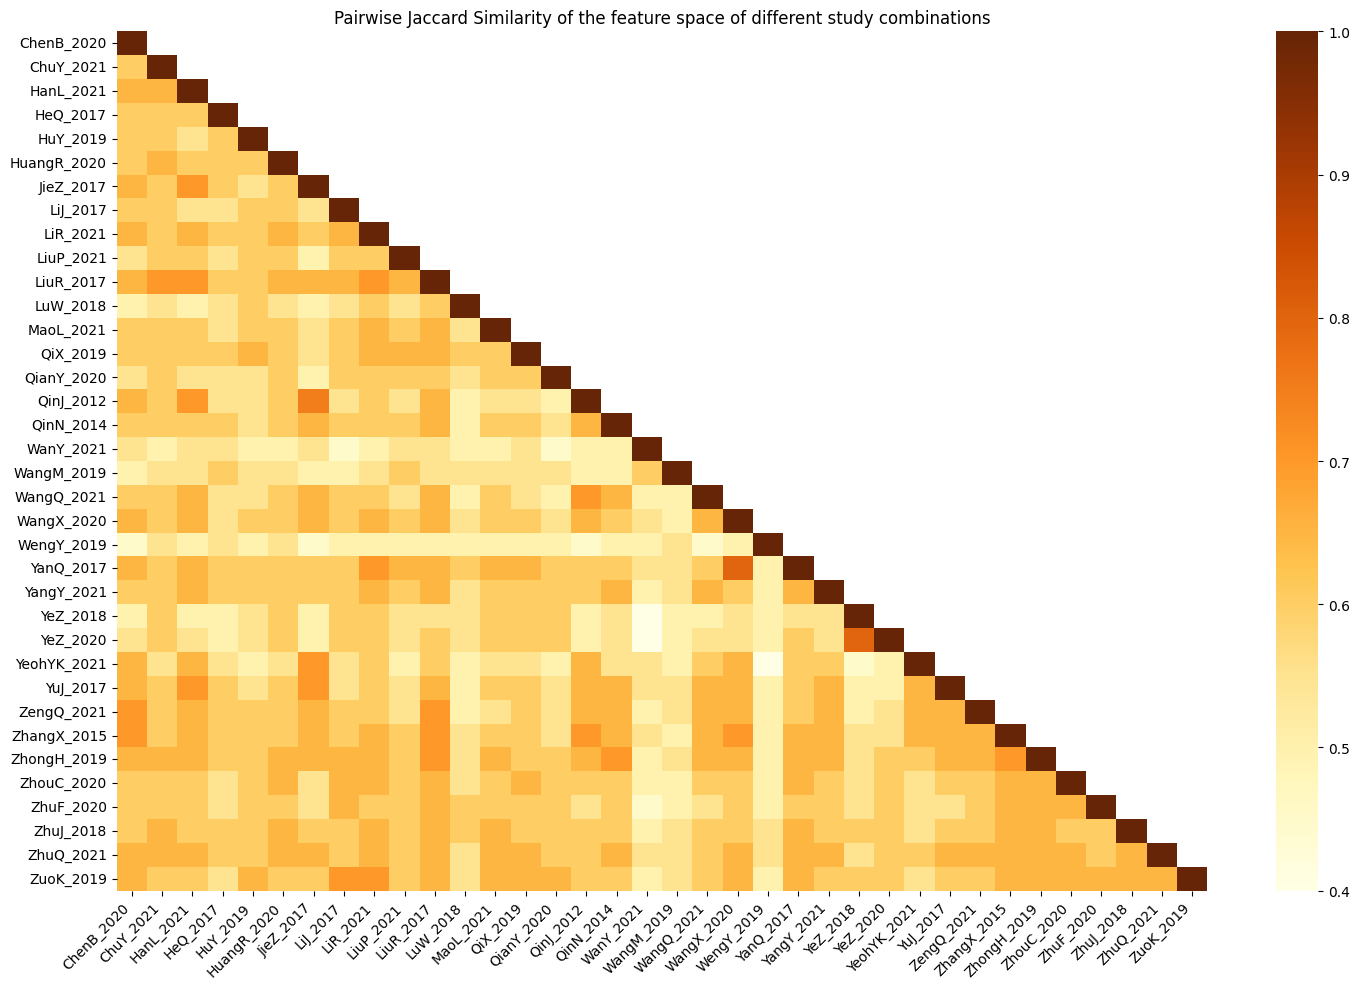

Value counts of pairwise Jaccard Similarity of the feature space of different study combinations


0
0.60    237
0.65    147
0.55    130
0.50     81
1.00     36
0.70     21
0.45      8
0.40      3
0.80      2
0.75      1
Name: count, dtype: int64

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

grouped_by_project = sample_group.groupby(sample_group["Project_1"])
studywise_nonzero_features = {}

for group, idx in grouped_by_project.groups.items():
    df = mpa4_species_profile.loc[idx]
    df_filtered = df.loc[
        :, (df.abs().sum(axis=0) != 0)
    ]  # TODO add absolute values function first (maybe negatives)
    studywise_nonzero_features[group] = set(list(df_filtered.columns))

keys = list(studywise_nonzero_features.keys())
n = len(keys)
jaccard_mat = np.zeros((n, n))

# Jaccard similarity calculation: defined as: |A ∩ B| / |A ∪ B|
for i in range(n):
    for j in range(n):
        set1 = studywise_nonzero_features[keys[i]]
        set2 = studywise_nonzero_features[keys[j]]
        # Calculate the intersection and union sizes:
        intersection_size = len(set1.intersection(set2))
        union_size = len(set1.union(set2))
        # Avoid division by zero
        jaccard_mat[i, j] = intersection_size / union_size if union_size > 0 else np.nan

# Create a DataFrame from the matrix for easier plotting
jaccard_df = pd.DataFrame(jaccard_mat, index=keys, columns=keys)


# Plot a heatmap using seaborn
def round_nearest(x, a):
    return round(x / a) * a


jaccard_df_rounded = round_nearest(jaccard_df, 0.05).where(
    np.tril(np.ones(jaccard_df.shape)).astype(np.bool)
)
plt.figure(figsize=(15, 10))
sns.heatmap(
    jaccard_df_rounded,
    annot=False,
    cmap=sns.color_palette("YlOrBr", as_cmap=True),
    fmt=".1f",
)
plt.title(
    "Pairwise Jaccard Similarity of the feature space of different study combinations"
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


jaccard_df_rounded = jaccard_df_rounded.stack().reset_index()
print(
    "Value counts of pairwise Jaccard Similarity of the feature space of different study combinations"
)
print_full_df(jaccard_df_rounded[0].value_counts())

## Clustering analysis

c:\Users\shaya\Documents\TU_projects\master_thesis\.thesis_venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\shaya\Documents\TU_projects\master_thesis\.thesis_venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

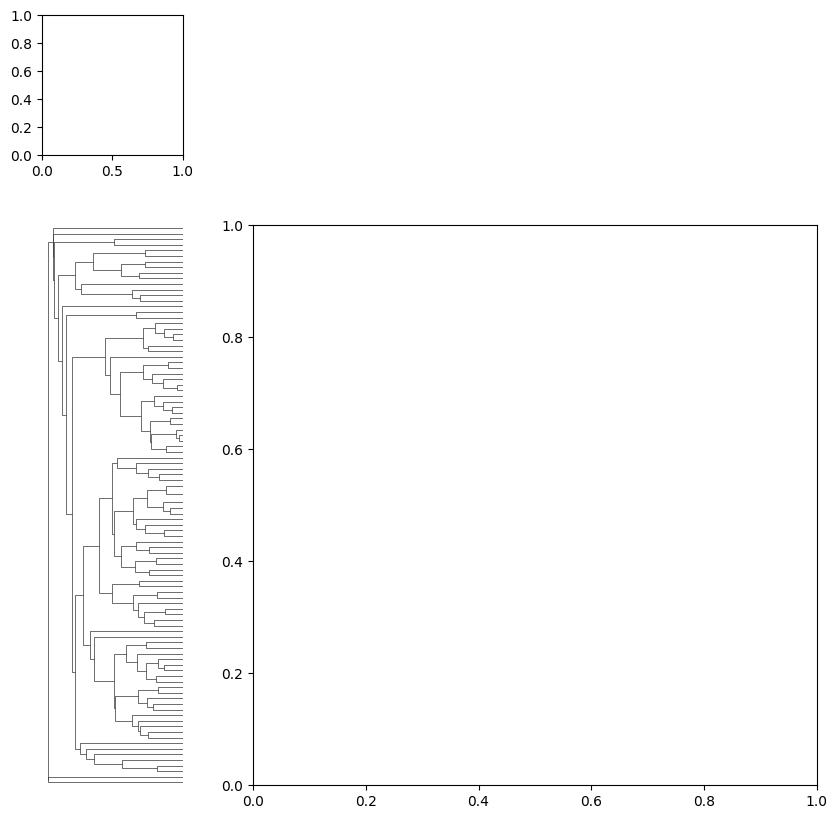

In [2]:
import numpy as np
import seaborn as sns

mpa4_species_profile = mpa4_species_profile.sort_index()
sample_group = sample_group.sort_index()

random_rows = np.random.randint(0, 6300, size=100)
random_cols = np.random.randint(0, 2550, size=100)
sample_group_rand = sample_group.iloc[random_rows, :]
mpa4_species_profile_rand = mpa4_species_profile.iloc[random_rows, random_cols]

sns.clustermap(mpa4_species_profile_rand, metric="braycurtis")